Today we are going to participate in Kaggle **Catch me if you can** competition (https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). Here we'll discuss the workflow - data preparation, feature analysis and other things. 

The goal of this notebook is not to **create perfect solution**, but to **come up with some good or bad ideas**. My team name is **Manny pardo**.

You are welcome to try to launch this notebook by yourself. But first you'll need all competition data (https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data)
...imported to 'data' folder in current path (where this notebook is). Then you'll need to exract train.zip to relative 'data/raw_data' subfolder. You should have this structure in the end:

![caption](structure.png)

In [1]:
# import dependencies
from __future__ import division, print_function

import warnings
import os
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import re
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# global consts
PATH_TO_DATA = 'data'
SPECIAL_USER_FILENAME = 'Alice_log.csv'
OTHER_USERS_PATH = 'other_user_logs'
RANDOM_SEED = 17
NGRAM_RANGE = (1,5)
NGRAM_FEATURES = 50000
WEEKDAY_NAMES = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
MONTH_NAMES = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
DAYTIME_RANGES = {
    'Morning': (0, range(7,11 + 1)),
    'Noon': (1, range(12,18 + 1)),
    'Evening': (2, range(19,23 + 1)),
    'Night': (3, range(0,6 + 1))
}

# global reg exps
nrmlzr_re = re.compile(r"^\S*?\.*?www\S*?\.", re.IGNORECASE)

## Data preparation 

Let's define some helper functions. We'll need them later

In [3]:
def get_dataframes(path_to_csv_files, normalize=False, return_names=True, certain=False):
    file_names = []
    dataframes = []
    
    # get all file names(.csv) from folder
    if certain:
        file_dirs = os.listdir(path_to_csv_files)
        csv_file_names = filter(lambda x: x.endswith(".csv"), file_dirs)
        file_names += [(path_to_csv_files, name) for name in csv_file_names]
    else:
        for folder, _, folder_file_names in os.walk(path_to_csv_files):
            csv_file_names = filter(lambda x: x.endswith(".csv"), folder_file_names)
            file_names += [(folder, name) for name in csv_file_names]
    
    # build Dataframes from the paths
    for file_name in file_names:
        dataframe =  pd.read_csv(file_name[0] + os.sep + file_name[1], engine='c')
        if normalize:
            # remove www.'s'
            dataframe['site'] = dataframe['site'].apply(lambda x: re.sub(nrmlzr_re,'', x))
        dataframes.append(dataframe)
        
    return (dataframes, file_names) if return_names else dataframes

def build_site_dict(data, with_freqs = False):
    sites_dict = dict()
    for idx, site in enumerate(data):
        if sites_dict.get(site) is None:
            sites_dict[site] = (1, idx)
        else:
            sites_dict[site] = (sites_dict[site][0] + 1, sites_dict[site][1])
    sites_counts_sorted = sorted(sites_dict.items(), key=lambda x: (x[1][0], -x[1][1]), reverse=True)
    sites_dict = {k: v for k, v in map(lambda x: (x[1][0], (x[0] + 1, x[1][1][0]) if with_freqs else x[0] + 1),
                                       enumerate(sites_counts_sorted))}
    return sites_dict

def normalize_data(dataframe, site_dict, return_dict = True):
    # build normalized dict from site_dict
    nrmlzed_pairs = map(lambda x: (re.sub(nrmlzr_re,'', x[0]), x[1]), site_dict.items())
    nrmlzed_sites = [site for site, site_id in sorted(nrmlzed_pairs, key = lambda x: x[1])]

    seen_sites = set()
    nrmlzed_unique_sites = [x for x in nrmlzed_sites if not (x in seen_sites or seen_sites.add(x))]
    nrmlzed_unique_pairs = [(site, idx + 1) for idx, site in enumerate(nrmlzed_unique_sites)]

    site_dict_norm = dict(nrmlzed_unique_pairs)
    site_dict_inverse = {value: key for (key, value) in site_dict.items()}
    
    # transform dataframe with normalized dict
    dataframe_norm = pd.DataFrame.copy(dataframe)
    site_columns = filter(lambda x: re.match('site\d+', x), dataframe.columns)
    for site_column in site_columns:
        re.sub(nrmlzr_re,'', x)
        dataframe_norm[site_column] = dataframe[site_column].apply(lambda x: 'None' if np.isnan(x) else re.sub(nrmlzr_re,'', site_dict_inverse[x]))
        dataframe_norm[site_column] = dataframe_norm[site_column].apply(lambda x: None if x == 'None' else site_dict_norm[x])
    return (dataframe_norm, site_dict_norm) if return_dict else dataframe_norm

The data is available at https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data. However, we want to build our own train set from the raw data (from  **train.zip**). So let's download and unpack it into the **raw_data** folder of the project. The main idea - is flexibility (we may want to experiment with some of these params in the future).

So, let's write the function for raw data import. The columns of the output are: **site(1),time(1),...site(n),time(n)** and **target**.

Params to specify:

- `path_to_csv_files` - path to data
- `site_freq_path`(optional) - path to sites frequency dictionary, it is crated online if there is none
- `session_length`(default = 10) - how many sites are in the row
- `window_size` (default = 10) - the step of iteration
- `time_limit` (optional) - time limit for one session
- `return_dict` (default = False) - whether to return dictionary
- `special_file` (optional) - filename to be considered as target==1 (and others will be 0), if it's not specified, then target is filename


In [4]:
def prepare_data(path_to_csv_files, special_file=None, site_freq_path=None, session_length=10, 
                                    window_size=10, time_limit = None, return_dict = False,
                                    bootstrap_step = False):
     
    dataframes, file_names = get_dataframes(path_to_csv_files)
    
    # get (or build) freqs dictionary
    if site_freq_path is None:
        sites_dict = build_site_dict(pd.concat(dataframes).site.values)
    else:
        with open(site_freq_path, 'rb') as f:
            sites_dict = pickle.load(f)
            
    # get column names
    site_columns = ['site' + str(idx+1) for idx in range(session_length)]
    time_columns = ['time' + str(idx+1) for idx in range(session_length)]
    columns = [column for ts_column in zip(site_columns, time_columns) for column in ts_column] + ['target']
    
    print('Composing dataframe of', len(file_names), 'files. Window size: ' +str(window_size))
    
    # build result Dataframe
    new_data_batch = []
    for dataframe, file_name in zip(dataframes, file_names):
        df_sorted = dataframe.sort_values('timestamp')
        sites_data = map(lambda x: sites_dict[x], dataframe['site'].values)
        timestamp_data = pd.to_datetime(dataframe['timestamp']).values
        data_len = dataframe.shape[0]

        prev_step = 0
        while prev_step < data_len:
            next_step = prev_step + session_length
            sites_ids = sites_data[prev_step:next_step]
            timestamps = timestamp_data[prev_step:next_step]
            if time_limit is not None:
                if (timestamps[-1] - timestamps[0]).astype('timedelta64[s]').astype(int) > time_limit * 60: # in seconds
                    threshold = timestamps[0] + time_limit * 60 * 10 ** 9 # in nanoseconds...
                    timestamps_limited = filter(lambda x: x <= threshold, timestamps)
                    next_step = prev_step + len(timestamps_limited)
                    sites_ids = sites_data[prev_step:next_step]
                    timestamps = timestamp_data[prev_step:next_step]
            sd_len = len(sites_ids)
            if sd_len != 0:
                new_row = dict.fromkeys(columns)
        
                # add sites ids
                for idx, col_name in enumerate(site_columns):
                    new_row[col_name] = int(sites_ids[idx]) if idx < len(sites_ids) else np.nan
                    
                # add visit times
                for idx, col_name in enumerate(time_columns):
                    new_row[col_name] = timestamps[idx] if idx < len(timestamps) else np.datetime64('NaT')
                    
                # add target
                new_row['target'] = file_name[1].replace('.csv','') if special_file is None else int(file_name[1] == special_file)
                
                new_data_batch.append(new_row)
                
            step_size = bootstrap_step if file_name[1] == special_file and bootstrap_step else window_size      
            prev_step = min(prev_step + step_size, next_step) + max(0, step_size - session_length)
 
    result = pd.DataFrame(new_data_batch, columns = columns)
    return (result, sites_dict) if return_dict else result

In [5]:
%%time
train_df, site_dict = prepare_data(path_to_csv_files=os.path.join(PATH_TO_DATA, 'raw_data'),
                                   site_freq_path=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
                                   special_file = SPECIAL_USER_FILENAME, time_limit=30, return_dict=True)

train_df_w9 = prepare_data(path_to_csv_files=os.path.join(PATH_TO_DATA, 'raw_data'),
                                   site_freq_path=os.path.join(PATH_TO_DATA, 'site_dic.pkl'), window_size=9,
                                   special_file = SPECIAL_USER_FILENAME, time_limit=30)

train_df_w11 = prepare_data(path_to_csv_files=os.path.join(PATH_TO_DATA, 'raw_data'),
                                   site_freq_path=os.path.join(PATH_TO_DATA, 'site_dic.pkl'), window_size=11,
                                   special_file = SPECIAL_USER_FILENAME, time_limit=30)

Composing dataframe of 1558 files. Window size: 10
Composing dataframe of 1558 files. Window size: 9
Composing dataframe of 1558 files. Window size: 11
Wall time: 38.6 s


In [6]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Because of strong imbalance, we're going to use **ROC AUC** scoring.

Let's sort train data by time and normalize the data - throw away the **www.** prefixes from the site names. Unfortunately we can't use our own site dictionary, we'll have to use **site_dic.pkl** - because otherwise our model won't predict anything close to the result. So we'll have to transform this dictionary to use it later.

In [7]:
%%time
train_df = train_df.sort_values(by='time1')
train_df_w9 = train_df_w9.sort_values(by='time1')
train_df_w11 = train_df_w11.sort_values(by='time1')

train_df, site_dict_norm = normalize_data(train_df, site_dict)
train_df_w9 = normalize_data(train_df_w9, site_dict, return_dict = False)
train_df_w11 = normalize_data(train_df_w11, site_dict, return_dict = False)

Wall time: 1min 2s


And here comes the test data:

In [8]:
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates=['time1'])
test_df = normalize_data(test_df, site_dict, return_dict = False)

Let's save everytihing with .txt format (appropriate for vectorizer)

In [9]:
site_columns = filter(lambda x: re.match('site\d+', x), train_df.columns)
time_columns = filter(lambda x: re.match('time\d+', x), train_df.columns)

train_df[site_columns].to_csv('train_sessions_text.txt', sep=' ', index=None, header=None)
train_df_w9[site_columns].to_csv('train_sessions_text_w9.txt', sep=' ', index=None, header=None)
train_df_w11[site_columns].to_csv('train_sessions_text_w11.txt', sep=' ', index=None, header=None)

test_df[site_columns].to_csv('test_sessions_text.txt', sep=' ', index=None, header=None)

Now we'll focus on default window size (=10) - we'll use 9 and 11 later (in the last section). Let's use the **CountVectorizer** to implement the bag of words (bag of sites) concept here.

In [10]:
%%time
cv = TfidfVectorizer(ngram_range=NGRAM_RANGE, max_features=NGRAM_FEATURES, tokenizer = lambda s: s.split())
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file) 
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
X_train.shape, X_test.shape

Wall time: 34.6 s


In [11]:
y_train = train_df['target'].astype('int').values

The data preparation is over. Let's see what do we have already. We'll do the estimations with logistic regression and time series cross validation strategy. Time series strategy seems appropriate, because we want to predict future by the past.

In [12]:
logit = LogisticRegression(C=1, random_state=RANDOM_SEED, solver='liblinear')
time_split = TimeSeriesSplit(n_splits=10)

In [13]:
%%time
cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)

Wall time: 8.11 s


In [14]:
print('Scores:', cv_scores) 
print('mean:', cv_scores.mean())
print('std:', cv_scores.std())

Scores: [ 0.81014999  0.64843412  0.86458692  0.94534758  0.83927298  0.89085384
  0.91077507  0.87887674  0.92577168  0.92087012]
mean: 0.863493904477
std: 0.0817162238468


Ok, good. Let's see the results on the public leaderboard. Let's define a function to write the submissions in required format:

In [15]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [16]:
logit.fit(X_train, y_train)
write_to_submission_file(logit.predict_proba(X_test)[:,1], 'results1.csv') # 0.91868

## Feature analysis

Our train and test sets are in the bag-of-words (bag of sites) format - which means that we allready retrieve a big part of static information. So let's start with time features.

### Time features

The features are (they are all stolen from public kernels):

   - `daytime` - time of the day when session starts: morning, noon, evening or night
   - `weekday` - day of week of the session start
   - `month` - month of the session start
   - `year` - year of the session start
   - `year_month` - year and monthof the same thing
   - `time_diff_sec` - session duration in seconds
   - `max_time_sec` - max visit time per session
   - `min_time_sec` - max visit time per session

In [17]:
def get_time_data(times, features=[]):
    data = dict.fromkeys(features)
    
    # parse iterative feature names    
    site_time_ftrs = filter(lambda x: re.match('time_spent_\d+', x), features)
    site_time_idxs = map(lambda x: int(re.search('\d+', x).group()), site_time_ftrs)
    
    times = times.ffill(axis=1)
    
    start_time = time_columns[0]
    end_time = time_columns[-1]
    
    start_datetimes = times[start_time]
    end_datetimes = times[end_time]
    next_datetimes = start_datetimes.values[1:]
    
    if 'weekday' in features:
        # add start weekday
        weekday_data = start_datetimes.apply(lambda x: x.weekday())
        # features += ['weekday']
        data['weekday'] = weekday_data
    
    if 'daytime' in features:
        # add start daytime  
        daytime_intervals = dict([(item, value) for key, (value, interval) in DAYTIME_RANGES.items() for item in interval])   
        daytime_data = start_datetimes.apply(lambda x: daytime_intervals[x.hour]).values 
        # features += ['daytime']
        data['daytime'] = daytime_data
        # data.append(daytime_data)
        
    if 'month' in features:
        # add start month
        month_data = start_datetimes.apply(lambda x: x.month - 1)
        data['month'] = month_data
        
    if 'year' in features:
        # add start year
        year_data = start_datetimes.apply(lambda x: x.year)
        data['year'] = year_data
        
    if 'hour' in features:
        # add start year
        hour_data = start_datetimes.apply(lambda x: x.hour / 24)
        data['hour'] = hour_data
        
    if 'year_month' in features:
        # add year + month
        year_data = start_datetimes.apply(lambda x: x.year)
        month_data = start_datetimes.apply(lambda x: x.month)
        data['year_month'] = (year_data * 100 + month_data) / 10 ** 5
    
    if 'time_diff_sec' in features:
        # add time diff between site1 and site10 
        timespans_data = (end_datetimes.values - start_datetimes.values).astype('timedelta64[s]').astype(int)
        data['time_diff_sec'] = timespans_data
        
    if 'max_time_sec' in features or 'min_time_sec' in features:
        if 'min_time_sec' in features:
            data['min_time_sec'] = []
        if 'max_time_sec' in features:
            data['max_time_sec'] = []
        # add max/min visit time (very heavy double for-in loops)
        for row in times.values:
            time_diffs = np.array([curr - prev for (curr,prev) in zip(row[1:],row)])
            time_diffs = time_diffs.astype('timedelta64[s]').astype(int)
            if 'max_time_sec' in features:
                data['max_time_sec'].append(max(time_diffs))
            if 'min_time_sec' in features:
                data['min_time_sec'].append(min(time_diffs))
         
    return pd.DataFrame(columns = features, data=data)

In [18]:
%%time
time_data = get_time_data(train_df[time_columns], ['weekday', 'daytime', 'time_diff_sec', 'month', 'hour',
                                                           'year', 'year_month', 'max_time_sec', 'min_time_sec'])
time_data['target'] = y_train

Wall time: 19.2 s


In [19]:
%%time
time_data_test = get_time_data(test_df[time_columns], ['weekday', 'daytime', 'time_diff_sec', 'month', 'hour',
                                                               'year', 'year_month', 'max_time_sec', 'min_time_sec'])

Wall time: 6.77 s


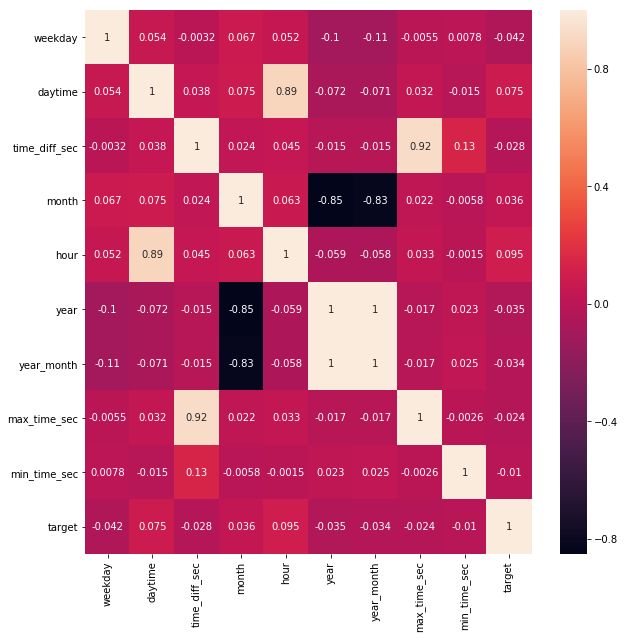

In [20]:
_, axes1 = plt.subplots(figsize=(10, 10))
sns.heatmap(time_data.corr(), annot=True, ax = axes1)

It's obvious that we should dispose of many features. Let's look closely at allof them.

In [21]:
data_parts = [time_data[time_data.target==1], time_data[time_data.target==0], time_data_test]
titles_default = ['Special user', 'Other users', 'Test set']

We'll look at stats pictures here - Special user (Alice), Other users and Test set. We want other users stats to strongly differ from special user stats - though it should mostly be alike test stats (or at least there should be some trend between them).

In [22]:
def draw_countplots(data, feature, titles = titles_default, labels=None):
    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
    for idx, data_part in enumerate(data_parts):
        sns.countplot(x=feature, data=data_part, ax=axes[idx]).set_title(titles[idx])
        if labels:
            axes[idx].set_xticklabels(labels = labels[idx])

In [23]:
def draw_pie_plot(train_data, test_data, column, color = "lightgreen", pct='%.2f%%', threshold = 0, title= None):
    special_subset = train_data[train_data.target == 1]
    others_subset = train_data[train_data.target == 0]
    
    remains_color = "lightgray"
    
    colors = (color, remains_color)

    sum_special = sum(special_subset[column] > threshold)
    sum_others = sum(others_subset[column] > threshold)
    sum_all = sum(train_data[column] > threshold)
     
    sum_test = sum(test_data[column] > threshold)
    
    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    axes[0] = plt.subplot2grid((1, 3),(0,0))
    plt.pie([sum_special, special_subset.shape[0] - sum_special], colors=colors, autopct=pct)
    plt.title('Special user: ' + (title or column))

    axes[1] = plt.subplot2grid((1, 3), (0, 1))
    plt.pie([sum_others, others_subset.shape[0] - sum_others], colors=colors, autopct=pct)
    plt.title('Other users: ' + (title or column))

    axes[2] = plt.subplot2grid((1, 3), (0, 2))
    plt.pie([sum_test, test_data.shape[0] - sum_test], colors=colors, autopct=pct)
    plt.title('Test set: ' + (title or column))

Weekday


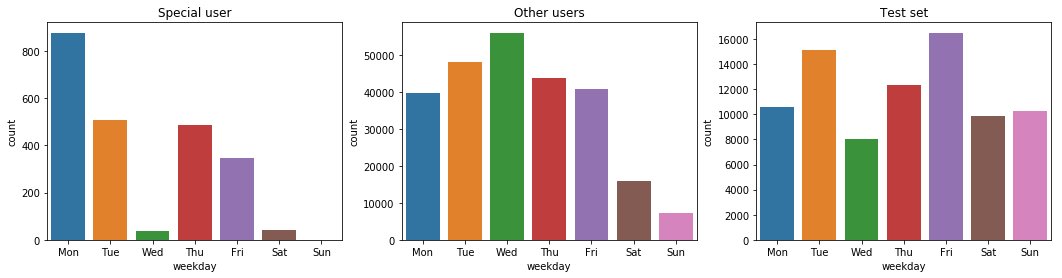

In [24]:
print('Weekday')
draw_countplots(data_parts, 'weekday', labels = [WEEKDAY_NAMES] * 3)

Daytime


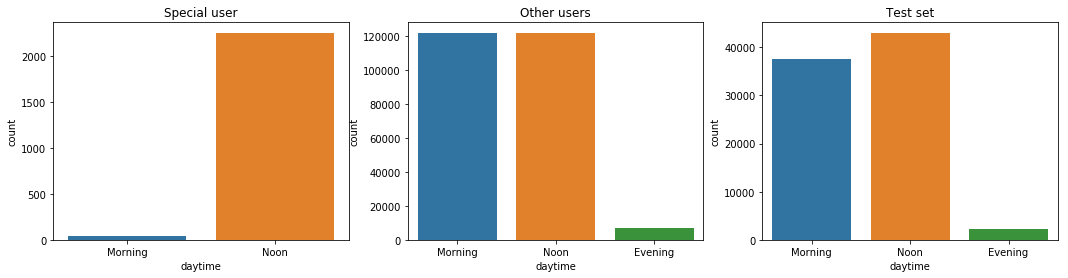

In [25]:
print('Daytime')
daytime_names = [key for key,value in sorted(DAYTIME_RANGES.items(), key=lambda x:x[1][0])]
draw_countplots(data_parts, 'daytime', labels = [daytime_names] * 3)

Month


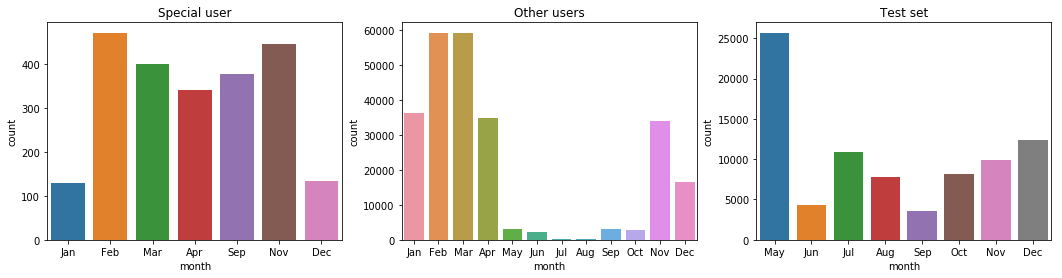

In [26]:
print('Month')
special_months = [MONTH_NAMES[idx] for idx in set(data_parts[0]["month"].values)]
test_months = [MONTH_NAMES[idx] for idx in set(data_parts[2]["month"].values)]

draw_countplots(data_parts, 'month', labels = [special_months, MONTH_NAMES, test_months])

Year


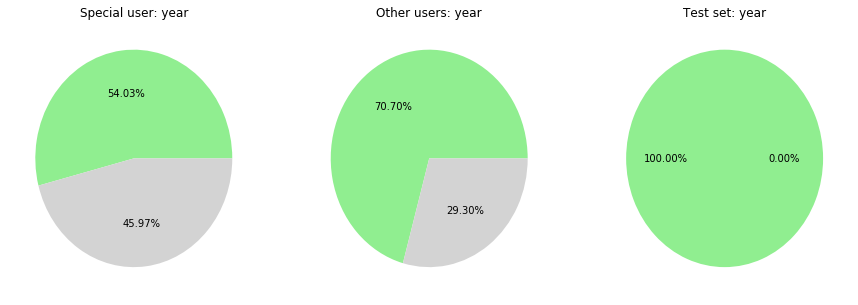

In [27]:
print('Year')
draw_pie_plot(time_data, time_data_test, 'year', threshold=2013)

So what do we see here? **daytime** is a perfect feature - special profile differs from the others in the train set and overall train set profile looks alike test one. **weekday** is not that good, because there are different behaviors in train and test sets, but still good enough. **month** and **year** - there is no sense to use them separately, because all test data 'happens after' the train data and there are only 8 months in test set. On the other hand, these are good separating features. This is where we'll need **year_month** trendy feature - there is no sence in visualising it.

You may also notice that we didn't consider the **hour** feature. That's because it's known fact that it leads to overfitting (https://inclass.kaggle.com/kashnitsky/model-validation-in-a-competition)

Now let's predict something. But first, let's do one hot encoding for **daytime**. Because there are only 3 values (only 2 for Alice) - treating them as numerical will get us worse results then if they were categorical.

In [28]:
def encode_features(dataframe, encode_map):
    df_copy = dataframe.copy()
    for feature, rule in encode_map.items():
        df_copy[feature] = df_copy[feature].apply(rule)
    return pd.get_dummies(df_copy, prefix=None)

In [29]:
dt_ranges_inv = {value: key for (key,(value, _)) in DAYTIME_RANGES.items()}
encode_map = {
    'daytime': lambda x: dt_ranges_inv[x]
}

time_data_encoded = encode_features(time_data, encode_map)
time_data_encoded_test = encode_features(time_data_test, encode_map)

In [30]:
%%time
X_train_time = hstack([X_train, 
                         time_data_encoded[['daytime_Evening', 'daytime_Morning', 
                                                'daytime_Noon', 'year_month', 'weekday']].values
                          ])

cv_scores4 = cross_val_score(logit, X_train_time, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

print('Scores:', cv_scores4) 
print('mean:', cv_scores4.mean())
print('std:', cv_scores4.std())

Scores: [ 0.83896615  0.80381977  0.92202695  0.97110525  0.9109996   0.95516553
  0.93964913  0.94825778  0.95909849  0.96578267]
mean: 0.921487131444
std: 0.0536516805583
Wall time: 10.7 s


In [31]:
X_test_time = hstack([X_test, time_data_encoded_test[['daytime_Evening', 'daytime_Morning', 
                                                'daytime_Noon', 'year_month', 'weekday']].values])

In [32]:
logit.fit(X_train_time, y_train)
write_to_submission_file(logit.predict_proba(X_test_time)[:,1], 'results2.csv') # 0.94664

Good, now let's look at remains.

Min visit time


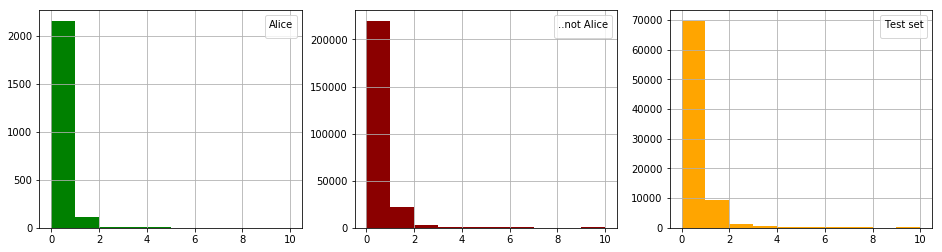

In [33]:
_, axes1 = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

colors_map = [('Alice', 'green'), ('..not Alice', 'darkred'), ('Test set', 'orange')]

print('Min visit time')

for data_idx, data in enumerate(data_parts):
    axes_obj = data['min_time_sec'].hist(ax = axes1[data_idx], bins=10, 
                                          range=(0,10), color = colors_map[data_idx][1]) 
    axes_obj.legend(loc='best', title=colors_map[data_idx][0], labels=[])

In [34]:
print('special: ', sum(data_parts[0]['min_time_sec'] > 0) / len(data_parts[0]))
print('others: ', sum(data_parts[1]['min_time_sec'] > 0) / len(data_parts[1]))
print('test set: ', data_parts[2]['min_time_sec'].mean())

special:  0.0613844144536
others:  0.125075617677
test set:  0.483447467903


Min time seem to have very small impact (due to heatmap), though the means are quite different. But it's intuitively understood, that minimal visit time per session can poorely separate anything. 

Session duration


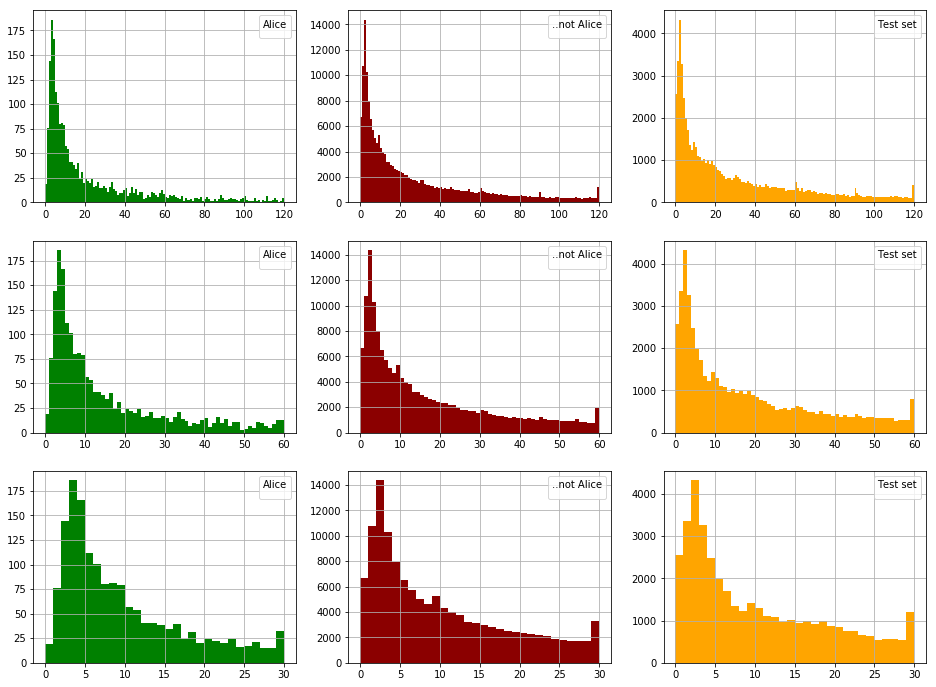

In [35]:
_, axes1 = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

scales  = [120, 60, 30]
colors_map = [('Alice', 'green'), ('..not Alice', 'darkred'), ('Test set', 'orange')]

print('Session duration')

for scale_idx, scale in enumerate(scales):
    for data_idx, data in enumerate(data_parts):
        axes_obj = data['time_diff_sec'].hist(ax = axes1[scale_idx][data_idx], bins=scale, 
                                              range=(0,scale), color = colors_map[data_idx][1]) 
        axes_obj.legend(loc='best', title=colors_map[data_idx][0], labels=[])

Here we look at different time ranges - (0-30, 0-60, 0-120 seconds). Means are:

In [36]:
print('special: ', data_parts[0]['time_diff_sec'].mean())
print('others: ', data_parts[1]['time_diff_sec'].mean())
print('test set: ', data_parts[2]['time_diff_sec'].mean())

special:  52.2964736613
others:  139.282372326
test set:  134.050195055


This feature is good (look at heatmap). It's obviously can be used but needs to be scaled first. Also we can throw away **max_time_sec** because these features are highly correleated. And intuitively overall duration should be better then max duration.

In [37]:
print('special: ', data_parts[0]['max_time_sec'].mean())
print('others: ', data_parts[1]['max_time_sec'].mean())
print('test set: ', data_parts[2]['max_time_sec'].mean())

special:  31.8014801916
others:  87.4928799987
test set:  84.0002415546


...or not. Let's see:

In [38]:
def scale_features(data_train, data_test = None, features = [], scaler = StandardScaler()):
    train_copy = data_train.copy()
    test_copy = data_test.copy()
    for feature in features:
        train_copy[feature] = scaler.fit_transform(train_copy[feature].astype('float64').values.reshape(-1, 1))
        if data_test is not None:
            test_copy[feature] = scaler.transform(test_copy[feature].astype('float64').values.reshape(-1, 1))
    return train_copy if data_test is None else (train_copy, test_copy)

In [39]:
(time_data_train_complete, time_data_test_complete) = scale_features(time_data_encoded, time_data_encoded_test,
                                                                    ['time_diff_sec', 'max_time_sec', 'min_time_sec'])

In [40]:
%%time
time_features = ['daytime_Evening', 'daytime_Morning', 'daytime_Noon', 'year_month', 'weekday']

X_train_time = hstack([X_train, time_data_train_complete[time_features + ['time_diff_sec']].values])
X_train_time_2 = hstack([X_train, time_data_train_complete[time_features + ['max_time_sec']].values])

cv_scores5_1 = cross_val_score(logit, X_train_time, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

cv_scores5_2 = cross_val_score(logit, X_train_time_2, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

Wall time: 25.5 s


In [41]:
print('Scores:', cv_scores5_1) 
print('mean:', cv_scores5_1.mean())
print('std:', cv_scores5_1.std())

Scores: [ 0.83026905  0.80652798  0.92289371  0.97102601  0.91305663  0.95680699
  0.94115882  0.94949586  0.9608151   0.96573405]
mean: 0.921778420726
std: 0.0547595506433


In [42]:
print('Scores:', cv_scores5_2) 
print('mean:', cv_scores5_2.mean())
print('std:', cv_scores5_2.std())

Scores: [ 0.83228816  0.80658029  0.9225538   0.97070904  0.91253031  0.95645428
  0.94075184  0.94930107  0.96034825  0.96579306]
mean: 0.921731011636
std: 0.0543178151393


So session duration feature (**time_diff_sec**) is better according to our cv strategy.

In [43]:
X_test_time = hstack([X_test, time_data_test_complete[time_features + ['time_diff_sec']].values])

In [44]:
logit.fit(X_train_time, y_train)
write_to_submission_file(logit.predict_proba(X_test_time)[:,1], 'results3.csv') # 0.95404

If we add **min_time_sec**, the cv score decreases a little bit, as expected:

In [45]:
%%time
X_train_time_3 = hstack([X_train, time_data_train_complete[time_features + ['time_diff_sec', 'min_time_sec']].values])

cv_scores5_3 = cross_val_score(logit, X_train_time_3, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

Wall time: 15.5 s


In [46]:
print('Scores:', cv_scores5_3) 
print('mean:', cv_scores5_3.mean())
print('std:', cv_scores5_3.std())

Scores: [ 0.82794353  0.806252    0.92273655  0.97102818  0.91304913  0.95680925
  0.9411926   0.94949194  0.96084337  0.96570064]
mean: 0.921504719536
std: 0.0552092287986


### Static features

So far we've got pretty solid results. Let's try to add some features independent of time:

   - `streak` - max same-site-streak (divided by 10 - for scaling purpouse)
   - `name_length` - mean (in session) lenth of site name - count of everything but dots in site name - (i.d.e. youtube.com == 2)
   - `duplicates_(n)` - count of sites visited more than n-1 times

In [47]:
def get_static_data(dataframe, site_dict_norm, features=[]):    
    
    # parse iterative feature names    
    start_ftrs = filter(lambda x: re.match('starts_with_\w+', x), features)
    start_sites = map(lambda x: x.replace('starts_with_', ''), start_ftrs)
    start_site_dict = dict.fromkeys(start_sites)
    for start_site in start_sites:
        start_site_dict[start_site] = [site_dict_norm[site_name] for site_name in site_dict_norm.keys() if start_site in site_name]
    
    end_ftrs = filter(lambda x: re.match('ends_with_\w+', x), features)
    end_sites = map(lambda x: x.replace('ends_with_', ''), end_ftrs)
    end_site_dict = dict.fromkeys(end_sites)
    for end_site in end_sites:
        end_site_dict[end_site] = [site_dict_norm[site_name] for site_name in site_dict_norm.keys() if end_site in site_name]
        
    duplicate_ftrs = filter(lambda x: re.match('duplicates_\d+', x), features)
    duplicate_idxs = map(lambda x: int(re.search('\d+', x).group()), duplicate_ftrs)
    
    # add features
    empty_arrays = [[] for i in range(len(features))]
    new_data_dict = dict(zip(features, empty_arrays))
  
    # inverse sites dictionary
    site_dict_norm_inv = {v: k for k,v in site_dict_norm.items()}
    
    for row in dataframe.values:   
            
        # add same sites streak
        if 'streak' in features:
            non_zero_data = filter(lambda x: x > 0, row)
            counts = []
            idx_count = 0
            for idx, t in enumerate(non_zero_data):
                if idx == 0:
                    idx_count += 1
                    if len(non_zero_data) == 1:
                        counts.append(idx_count)
                    continue

                if non_zero_data[idx] == non_zero_data[idx - 1]:
                    idx_count += 1
                    if idx == len(non_zero_data) - 1:
                        counts.append(idx_count)
                else:
                    counts.append(idx_count)
                    idx_count = 1
                    if idx == len(non_zero_data) - 1:
                        counts.append(idx_count)
            new_data_dict['streak'].append(len(counts) and max(counts))
            
        # add site name length
        if 'name_length' in features:
            site_names = [site_dict_norm_inv[site_id] for site_id in row if site_id > 0]
            name_lengths = map(lambda x: len(x.split('.')), site_names)
            new_data_dict['name_length'].append(sum(name_lengths)/len(name_lengths))
            
        # add duplicate count
        for dup_idx in duplicate_idxs:
            unique_sites = set(row)
            if 0 in unique_sites:               
                unique_sites.remove(0)
            duplicate_counts = filter(lambda x: x >= dup_idx, [list(row).count(site) for site in unique_sites])
            new_data_dict['duplicates_' + str(dup_idx)].append(len(duplicate_counts))
             
    return pd.DataFrame(columns = features, data=new_data_dict)

In [48]:
%%time
static_features = ['streak', 'name_length', 'duplicates_2', 'duplicates_3', 'duplicates_4']
static_data = get_static_data(train_df[site_columns], site_dict_norm, features=static_features)
static_data['target'] = y_train

Wall time: 21.2 s


In [49]:
%%time
static_data_test = get_static_data(test_df[site_columns], site_dict_norm, features=static_features)

Wall time: 6.64 s


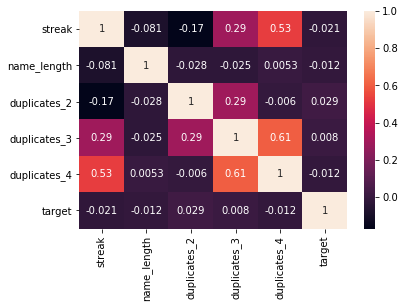

In [50]:
sns.heatmap(static_data.corr(), annot=True)

Well, at first glance these features look much worse.

In [51]:
data_parts = [static_data[static_data.target==1], static_data[static_data.target==0], static_data_test]
titles_default = ['Special user', 'Other users', 'Test set']

Duplicates 2


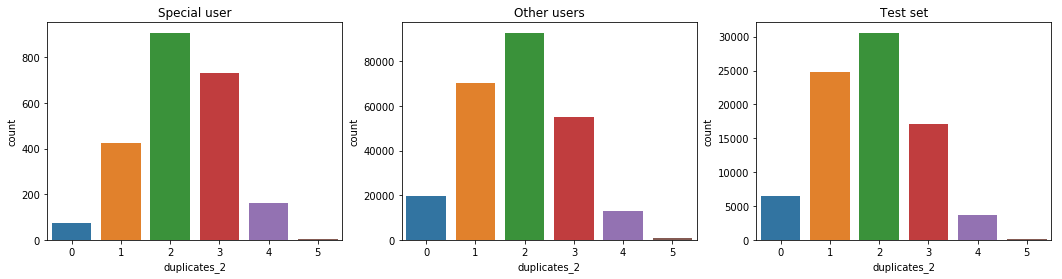

In [52]:
print('Duplicates 2')
draw_countplots(data_parts, 'duplicates_2')

Duplicates 3


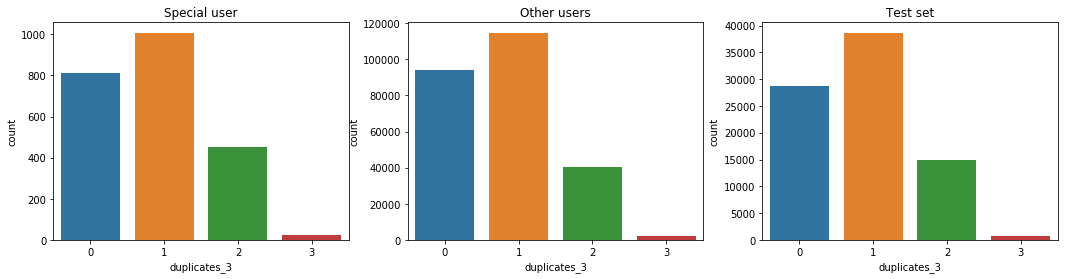

In [53]:
print('Duplicates 3')
draw_countplots(data_parts, 'duplicates_3')

Duplicates 4


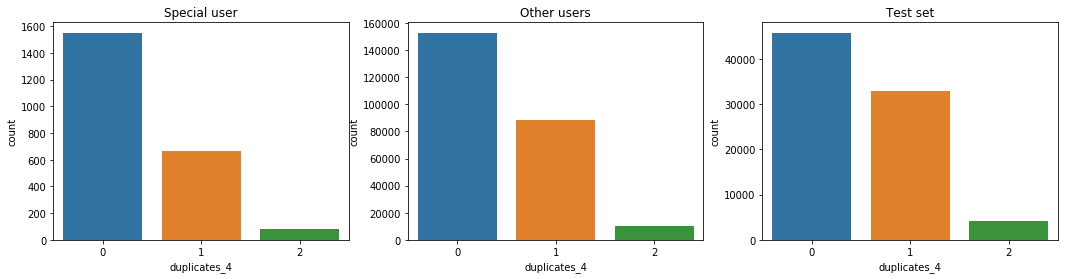

In [54]:
print('Duplicates 4')
draw_countplots(data_parts, 'duplicates_4')

Average name length


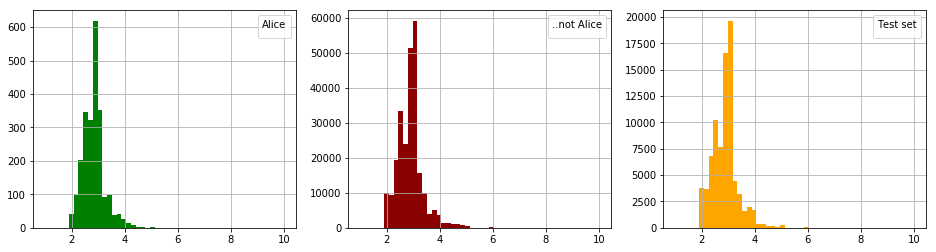

In [55]:
_, axes1 = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
colors_map = [('Alice', 'green'), ('..not Alice', 'darkred'), ('Test set', 'orange')]

print('Average name length')

for data_idx, data in enumerate(data_parts):
    axes_obj = data['name_length'].hist(ax = axes1[data_idx], bins = 50,
                                          range=(1,10), color = colors_map[data_idx][1])
    axes_obj.legend(loc='best', title=colors_map[data_idx][0], labels=[])

Streak


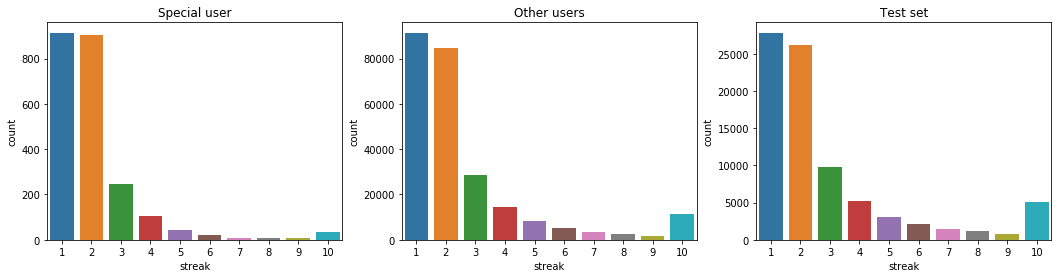

In [56]:
print('Streak')
draw_countplots(data_parts, 'streak')

Well, we could use **duplicates_2**, **name_length** and **streak**. Let's see what happens.

In [57]:
%%time
X_train_time_static = hstack([X_train_time, static_data[['name_length', 'duplicates_2', 'streak']].values])

cv_scores2 = cross_val_score(logit, X_train_time_static, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)

Wall time: 17.5 s


In [58]:
print('Scores:', cv_scores2) 
print('mean:', cv_scores2.mean())
print('std:', cv_scores2.std())

Scores: [ 0.83601387  0.80629654  0.9247796   0.96922409  0.89854958  0.95100359
  0.93724262  0.95020346  0.95844026  0.96473867]
mean: 0.919649228524
std: 0.0534199150471


In [59]:
X_test_time_static = hstack([X_test_time, static_data_test[['name_length', 'duplicates_2', 'streak']].values])

Well, no. These features don't look too good. However, just out of the interest, let's make a submission.

In [60]:
logit.fit(X_train_time_static, y_train)
write_to_submission_file(logit.predict_proba(X_test_time_static)[:,1], 'results4.csv') # 0.95433

This could mean several different things:

1. Our cv strategy is not appropriate.
2. The features are very insignificant, and we somehow were lucky to improve the LB score, because of high variance.
3. Issues with train data.

We'll get back to these suggestions later. Now let's just consider these features as 'bad ones', but remember about them.

### Combined features

Now it's time to come up with features, combining static and time info.

   - `time_spent(x)` - time spent on x-like site (i.d.e. **youtube** - is for **youtube.com** and **s.youtube.com**)
   - `streak time spent` - time spent on site streak visit  

In [61]:
def get_combined_data(dataframe, site_dict_norm, features=[]):
    data = dict.fromkeys(features)
    
    # parse iterative feature names    
    time_spent_ftrs = filter(lambda x: re.match('time_spent_\w+', x), features)
    time_spent_sites = map(lambda x: x.replace('time_spent_', ''), time_spent_ftrs)
    time_spent_dict = dict.fromkeys(time_spent_sites)    
    for ts_site in time_spent_sites:
        time_spent_dict[ts_site] = [site_dict_norm[site_name] for site_name in site_dict_norm.keys() if ts_site in site_name]
        
    # parse iterative feature names    
    time_spent_top_ftrs = filter(lambda x: re.match('time_spent_top_\d+', x), features)
    time_spent_tops = map(lambda x: x.replace('time_spent_top_', ''), time_spent_top_ftrs)
    
    times = dataframe[time_columns].ffill(axis=1)
    sites = dataframe[site_columns]
    
    # add timespent on x-like site
    if len(time_spent_ftrs) > 0:
        for ftr in time_spent_ftrs:
            data[ftr] = []
        for site_row, time_row in zip(sites.values, times.values):
            time_diffs = np.array([curr - prev for (curr,prev) in zip(time_row[1:],time_row)])
            time_diffs = time_diffs.astype('timedelta64[s]').astype(int)  
            for ts_site in time_spent_sites:
                corr_idxs = time_spent_dict[ts_site]
                if len(set(corr_idxs) & set(site_row[:-1])) == 0:
                    data['time_spent_'+ts_site].append(0)
                else:
                    site_durations = [diff for (idx, diff) in enumerate(time_diffs) if site_row[idx] in corr_idxs]
                    data['time_spent_'+ts_site].append(sum(map(int, site_durations)) + 1)
    
    # add time spent within streak
    if 'time_spent_streak' in features:
        data['time_spent_streak'] = []
        for site_row, time_row in zip(sites.values, times.values):
            non_zero_data = filter(lambda x: x > 0, site_row)
            time_row = time_row[:len(non_zero_data)]

            if len(non_zero_data) == 1:
                data['time_spent_streak'].append(0)
            else:
                idxd_difference = enumerate([idx2 -idx1 for (idx1, idx2) in zip(non_zero_data, non_zero_data[1:])])
                time_diff_idxs = [idx for (idx,_) in filter(lambda x: x[1] == 0, idxd_difference)]
                time_diffs = (time_row[1:] - time_row[:-1])[time_diff_idxs]
                sum_time_diff = sum(time_diffs.astype('timedelta64[s]').astype(int))
                data['time_spent_streak'].append(sum_time_diff + 1)
     
    return pd.DataFrame(columns = features, data=data)

In [62]:
%%time
time_spents = ['time_spent_'+ site_part for site_part in ['vk.', 'facebook', 'live.']]
combined_data = get_combined_data(train_df, site_dict_norm, features=['time_spent_streak'] + time_spents)

Wall time: 54.1 s


In [63]:
combined_data['target'] = y_train

In [64]:
combined_data_test = get_combined_data(test_df, site_dict_norm, features=['time_spent_streak'] + time_spents)

In [65]:
all_data = [combined_data[combined_data.target == 1], combined_data[combined_data.target == 0], combined_data_test]

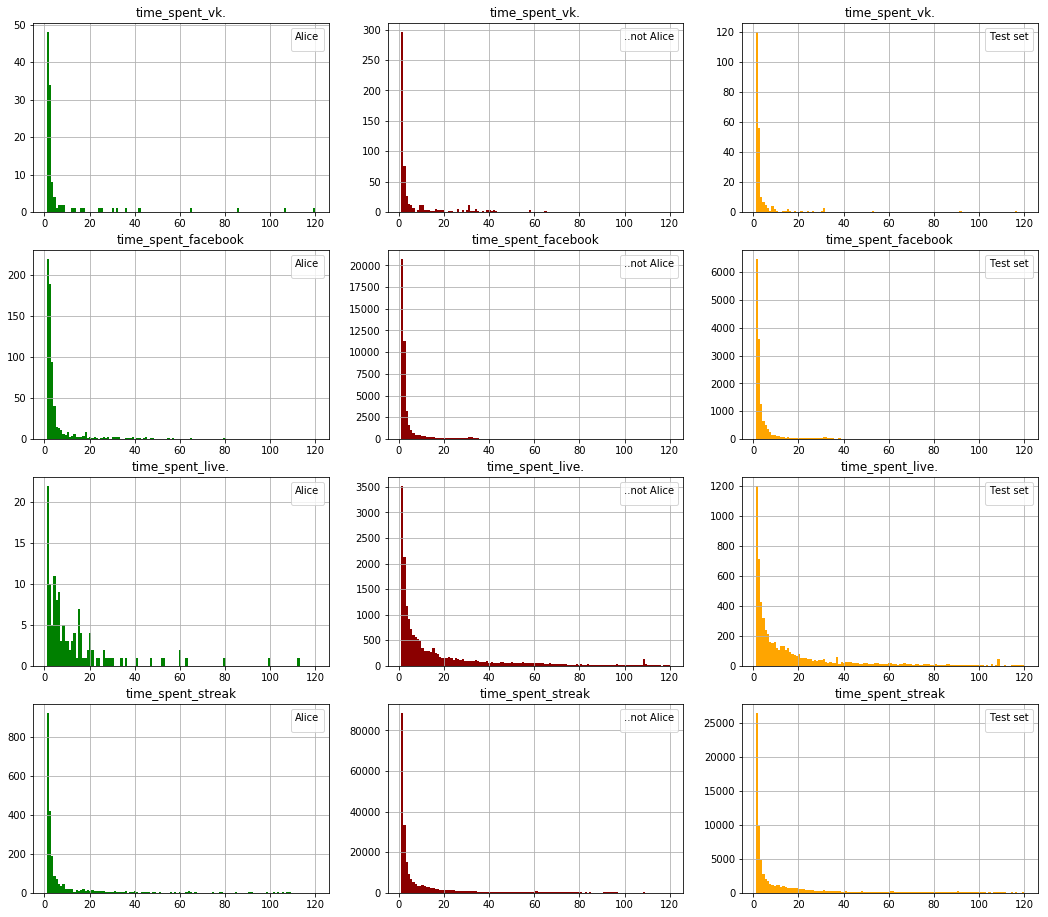

In [66]:
_, axes1 = plt.subplots(nrows=len(time_spents) + 1, ncols=3, figsize=(18, 16))

colors_map = [('Alice', 'green'), ('..not Alice', 'darkred'), ('Test set', 'orange')]

for spent_idx, spent_time_site in enumerate(time_spents + ['time_spent_streak']) :
    data = map(lambda x: x[spent_time_site], all_data)
    for data_idx, data_part in enumerate(data):
        axes_obj = (data_part).hist(ax = axes1[spent_idx][data_idx], bins=120,
                                              range=(1,120), color = colors_map[data_idx][1])
        axes_obj.set_title(spent_time_site)
        axes_obj.legend(loc='best', title=colors_map[data_idx][0], labels=[])

In [67]:
print('time_spent_streak:')
print('special: ', all_data[0]['time_spent_streak'].mean())
print('others: ', all_data[1]['time_spent_streak'].mean())
print('test set: ', all_data[2]['time_spent_streak'].mean())

time_spent_streak:
special:  18.7496734872
others:  37.6278177534
test set:  43.1153544211


In [68]:
print('time_spent_vk.:')
print('special: ', all_data[0]['time_spent_vk.'].mean())
print('others: ', all_data[1]['time_spent_vk.'].mean())
print('test set: ', all_data[2]['time_spent_vk.'].mean())

time_spent_vk.:
special:  9.54592947323
others:  0.0233698420785
test set:  0.0552435474715


In [69]:
(combined_data_train_complete, combined_data_test_complete) = scale_features(combined_data, combined_data_test,
                                                                    ['time_spent_streak', 'time_spent_vk.',
                                                                     'time_spent_facebook', 'time_spent_live.'])

Let's try out the **time_spent_streak** feature.

In [70]:
%%time
X_train_time_combined = hstack([X_train_time, combined_data_train_complete[['time_spent_streak']].values])

cv_scores7 = cross_val_score(logit, X_train_time_combined, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)

Wall time: 19.1 s


In [71]:
print('Scores:', cv_scores7) 
print('mean:', cv_scores7.mean())
print('std:', cv_scores7.std())

Scores: [ 0.83220735  0.80651356  0.92347955  0.97037254  0.91266959  0.95679569
  0.94120869  0.94970039  0.96101735  0.9657289 ]
mean: 0.921969361435
std: 0.0544155983832


Ok, good. What about like-sites **vk**, **live** and **facebook**? Well, i'll spoil it without estimations presented. These are bad features - the ones that increase LB score, decreasing CV score. How did i come with these? Experimenting, dramatically increasing  number of submissions. This is very bad approach. That shouldn't have been ever done. However, let's remember them just like bad static features.

In [72]:
%%time
X_test_time_combined = hstack([X_test_time, combined_data_test_complete[['time_spent_streak']].values])

Wall time: 55 ms


In [73]:
logit.fit(X_train_time_combined, y_train)
write_to_submission_file(logit.predict_proba(X_test_time_combined)[:,1], 'results5.csv') # 0.95378

...and we go down. Why? Well... we should have noticed one thing - high correlation with **time_diff_sec**. Generally, everything, that is connected with generalized time spent, will correlate with it. The bad features above, however, not - because they are rather pinpoint then general.

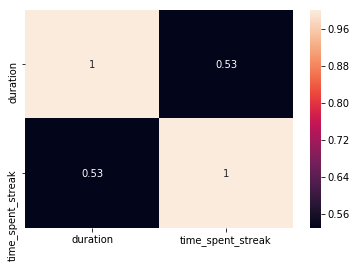

In [74]:
check_df = pd.DataFrame(data = {
    'duration': time_data['time_diff_sec'].values, 
    'time_spent_streak': combined_data['time_spent_streak'].values
})

sns.heatmap(check_df.corr(), annot=True)

Combining everything into one function:

In [75]:
def get_data_by_features(dataframe, dataframe_test, site_dict_norm, time_features = [], static_features = [], 
                         combined_features = [], encode_map = None, features_to_scale = []):
    
    site_columns = filter(lambda x: re.match('site\d+', x), dataframe.columns)
    time_columns = filter(lambda x: re.match('time\d+', x), dataframe.columns)
    
    t_data_train = get_time_data(dataframe[time_columns], time_features)
    s_data_train = get_static_data(dataframe[site_columns], site_dict_norm, static_features)
    c_data_train = get_combined_data(dataframe, site_dict_norm, combined_features)
    
    t_data_test = get_time_data(dataframe_test[time_columns], time_features)
    s_data_test = get_static_data(dataframe_test[site_columns], site_dict_norm, static_features)
    c_data_test = get_combined_data(dataframe_test, site_dict_norm, combined_features)
    
    dfs_to_concat = []
    dfs_to_concat_test = []
    if len(time_features) > 0:
        dfs_to_concat.append(t_data_train)
        dfs_to_concat_test.append(t_data_test)
    if len(static_features) > 0:
        dfs_to_concat.append(s_data_train)
        dfs_to_concat_test.append(s_data_test)
    if len(combined_features) > 0:
        dfs_to_concat.append(c_data_train)
        dfs_to_concat_test.append(c_data_test)
    
    result_df = pd.concat(dfs_to_concat, axis = 1)
    result_df_test = pd.concat(dfs_to_concat_test, axis = 1)
    
    if encode_map is not None:
        result_df = encode_features(result_df, encode_map)
        result_df_test = encode_features(result_df_test, encode_map)
    
    if len(features_to_scale) > 0:
        (result_df, result_df_test) = scale_features(result_df, result_df_test, features_to_scale)
        
    return (result_df, result_df_test)

## 3.Training set manipulation and parameters tuning

Let's check out, what's going on with our train set. May be we don't need all of it.

In [76]:
def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right')

In [77]:
def plot_validation_curves(param_values, grid_cv_results_, up_to=-1):
    train_mu, train_std = grid_cv_results_['mean_train_score'][:up_to], grid_cv_results_['std_train_score'][:up_to]
    valid_mu, valid_std = grid_cv_results_['mean_test_score'][:up_to], grid_cv_results_['std_test_score'][:up_to]
    
    train_line = plt.plot(param_values[:up_to], train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values[:up_to], valid_mu, '-', label='test', color='red')
    
    plt.fill_between(param_values[:up_to], train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values[:up_to], valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend() 

In [78]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
# estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(X = X_train_time, y=y_train, scoring='roc_auc', n_jobs = 4,
                                              estimator=logit, train_sizes= train_sizes, 
                                              cv = time_split)

Wall time: 19 s


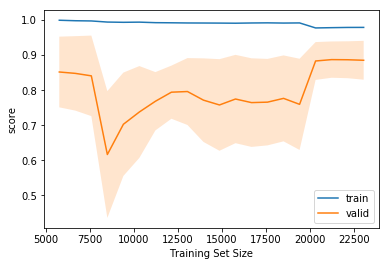

In [79]:
plot_learning_curve(val_train, val_test, n_train)

Why is that? Well, it turns out, that there is no labels, equal to 1 in **y_train** since some point. And because train set is pretty imbalanced, this makes sense. 

In [80]:
last_1_index = max([idx for (idx, value) in enumerate(y_train) if value == 1])
train_part_actual = last_1_index/len(y_train)
train_part = int(train_part_actual * X_train.shape[0])

In [81]:
train_part

237674

In [82]:
X_train_actual = X_train_time.tocsr()[:train_part]
y_train_actual = y_train[:train_part]

In [83]:
logit.fit(X_train_actual, y_train_actual)
write_to_submission_file(logit.predict_proba(X_test_time)[:,1], 'results6.csv') # 0.95457

So, yes, the assumption was right (as you can see, we don't use bad featurs here). Now let's tune ourselves the regulariztion parameter.

In [84]:
%%time
c_values = np.logspace(-4, 2, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=4, cv=time_split, verbose=1)
logit_grid_searcher.fit(X_train_actual, y_train_actual);

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.7min finished


Wall time: 3min 50s


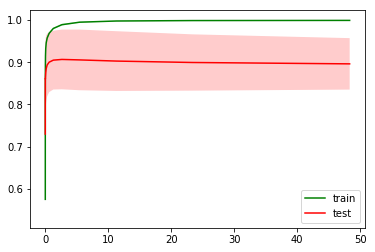

In [85]:
plot_validation_curves(c_values, logit_grid_searcher.cv_results_)

Let's search it in narrow range now.

In [86]:
%%time
c_values = np.linspace(1, 5, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=4, cv=time_split, verbose=1)
logit_grid_searcher.fit(X_train_actual, y_train_actual);

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  4.5min finished


Wall time: 4min 39s


Optimal C and best score are:

In [87]:
logit_grid_searcher.best_params_['C'], logit_grid_searcher.best_score_

(2.6842105263157894, 0.90675008367114596)

In [88]:
logit_tuned = LogisticRegression(random_state = 17, C = logit_grid_searcher.best_params_['C'], solver = 'liblinear')
logit_tuned.fit(X_train_actual, y_train_actual)
write_to_submission_file(logit_tuned.predict_proba(X_test_time)[:,1], 'results7.csv') # 0.95582

Ok, good. Now, let's try to cheat our way up the LB...

## 4.Blending

I have no idea how to do that properly. But i think the idea is to manually construct the hyperplane, that would separate  classes better than single estimator would do. There is no appropriate way to check the output - only submission. So we MUST come up with good suggestions.

As i see it, we need several different estimators - each of them should be overfitted in it's own way, so the averages (or weighted averages) of their predictions would be closer to the actual probabilities. Also we would need the corrector estimator (let's use the one we've got) - and then we'll get the averages from their results. 

In [89]:
sgd_logit = SGDClassifier(loss='log', random_state = RANDOM_SEED)
linear_svm = SVC(kernel = 'linear', random_state= RANDOM_SEED, probability = True, class_weight = 'balanced')

The next line executes for ridiculously big amount of time, so let's use the precomputed results. You may however uncomment this if you want (not recommended). We skip parameters tuning for obvious reasons - it most likely will never end.

LB score for svm is 0.94333 which is quite lower, but it can be used in combination with logistic regression.

In [90]:
# %%time
# linear_svm.fit(X_train_actual, y_train_actual)
# write_to_submission_file(linear_svm.predict_proba(X_test_time)[:,1], 'svm_results.csv')

In [91]:
# svm_predict = linear_svm.predict_proba(X_test_time)[:,1]
svm_predict = pd.read_csv('svm_results.csv')['target'].values

In [92]:
logit_predict = logit_tuned.predict_proba(X_test_time)[:, 1]

Now let's add bad features.

In [93]:
X_train_full = hstack([X_train_actual, 
                       static_data[['duplicates_2', 'streak', 'name_length']][:train_part].values,
                       combined_data_train_complete[['time_spent_vk.', 'time_spent_facebook', 'time_spent_live.']][:train_part].values
                      ])

X_test_full = hstack([X_test_time, 
                       static_data_test[['duplicates_2', 'streak', 'name_length']].values,
                       combined_data_test_complete[['time_spent_vk.', 'time_spent_facebook', 'time_spent_live.']][:train_part].values
                      ])

Note that we can't tune the params - because cv results do not correspond to LB results. We can only look at resulting weights to try to suggest the optimal C. Let's say it's 2.

In [94]:
logit_tuned_2 = LogisticRegression(random_state = 17, C = 2, solver = 'liblinear')

In [95]:
logit_tuned_2.fit(X_train_full, y_train_actual)
logit_predict_2 = logit_tuned_2.predict_proba(X_test_full)[:, 1]

In [96]:
def get_top_weights(vectorizer, site_dict_norm, estimator, top_n = 10):
    vectorizer_dict = {v:k for k, v in vectorizer.vocabulary_.items()}
    site_dict_norm_inv = {v:k for k, v in site_dict_norm.items()}
    
    sorted_weights = sorted(enumerate(estimator.coef_[0]), key = lambda x: -x[1])[:top_n] 
    sequence_freq = map(lambda x: (vectorizer_dict[x[0]].split(' '), x[1]), sorted_weights)
    
    result = []
    for seq, freq in sequence_freq:
        site_names = [site_dict_norm_inv[int(float(site_id))] for site_id in seq]
        result.append((' '.join(site_names), freq))
        
    return result

The weights are (for model with bad features):

In [97]:
get_top_weights(cv, site_dict_norm, logit_tuned_2)

[(u'express.co.uk', 8.8739082407240097),
 (u'cid-ed6c3e6a5c6608a4.users.storage.live.com', 7.0529979958165514),
 (u'fr.glee.wikia.com', 5.3400420701663949),
 (u'browser-update.org', 5.0392769093591854),
 (u'audienceinsights.net', 5.0386351989296303),
 (u'video.tt', 4.9532057756320507),
 (u's.radio-canada.ca', 4.8961169840761958),
 (u'youwatch.org', 4.882129405298377),
 (u'banque-chalus.fr', 4.7693384794305507),
 (u'melty.fr', 4.7458174838283673)]

The weights are (for our best model):

In [98]:
get_top_weights(cv, site_dict_norm, logit_tuned)

[(u'express.co.uk', 9.9176666424202562),
 (u'cid-ed6c3e6a5c6608a4.users.storage.live.com', 8.0630828151111498),
 (u'browser-update.org', 5.8877478285747857),
 (u'fr.glee.wikia.com', 5.6059453310291403),
 (u's.radio-canada.ca', 5.4578853233134286),
 (u'tru.am', 5.2908148065485268),
 (u'video.tt', 5.271570609104657),
 (u'audienceinsights.net', 5.2267268782052945),
 (u'banque-chalus.fr', 5.1659738006295228),
 (u'brgm.fr', 5.165254337161028)]

So, our model with bad features doesn't look ovefitted too much at least.

Now let's look at online learning models. We'll add train sets with 9 and 11 window sizes.

In [99]:
%%time
with open('train_sessions_text_w9.txt') as inp_train_file_w9:
    X_train_w9 = cv.transform(inp_train_file_w9) 
with open('train_sessions_text_w11.txt') as inp_train_file_w11:
    X_train_w11 = cv.transform(inp_train_file_w11)

Wall time: 26.6 s


In [100]:
y_train_w9 = train_df_w9['target'].astype(int)
y_train_w11 = train_df_w11['target'].astype(int)

In [101]:
%%time
dt_ranges_inv = {value: key for (key,(value, _)) in DAYTIME_RANGES.items()}
encode_map = {
    'daytime': lambda x: dt_ranges_inv[x]
}

time_features=['daytime', 'year_month', 'weekday', 'time_diff_sec']
features_to_scale = ['time_diff_sec']

(data_w9_train, data_w9_test) = get_data_by_features(train_df_w9, test_df, site_dict_norm,
                                              time_features = time_features,
                                              encode_map = encode_map,                                                             
                                              features_to_scale = features_to_scale)

(data_w11_train, data_w11_test) = get_data_by_features(train_df_w11, test_df, site_dict_norm,
                                              time_features = time_features,
                                              encode_map = encode_map,
                                              features_to_scale = features_to_scale)

Wall time: 21.8 s


In [102]:
X_train_w9_final = hstack([X_train_w9, data_w9_train])
X_test_w9_final = hstack([X_test, data_w9_test])

X_train_w11_final = hstack([X_train_w11, data_w11_train])
X_test_w11_final = hstack([X_test, data_w11_test])

In [103]:
sgd_logit_w9 = SGDClassifier(loss='log', random_state = RANDOM_SEED)
sgd_logit_w11 = SGDClassifier(loss='log', random_state = RANDOM_SEED)

In [104]:
%%time
sgd_logit.fit(X_train_time, y_train)
sgd_logit_w9.fit(X_train_w9_final, y_train_w9)
sgd_logit_w11.fit(X_train_w11_final, y_train_w11)

sgd_w9_predict = sgd_logit_w9.predict_proba(X_test_w9_final)[:,1]
sgd_w11_predict = sgd_logit_w11.predict_proba(X_test_w11_final)[:,1]
sgd_predict = sgd_logit.predict_proba(X_test_time)[:,1]

Wall time: 2.03 s


In [105]:
predict_df = pd.DataFrame(data = {
    'logit': logit_predict,
    'logit_bf': logit_predict_2,
    'svm': svm_predict,
    'sgd': sgd_predict,
    'sgd_w9': sgd_w9_predict,
    'sgd_w11': sgd_w11_predict  
})

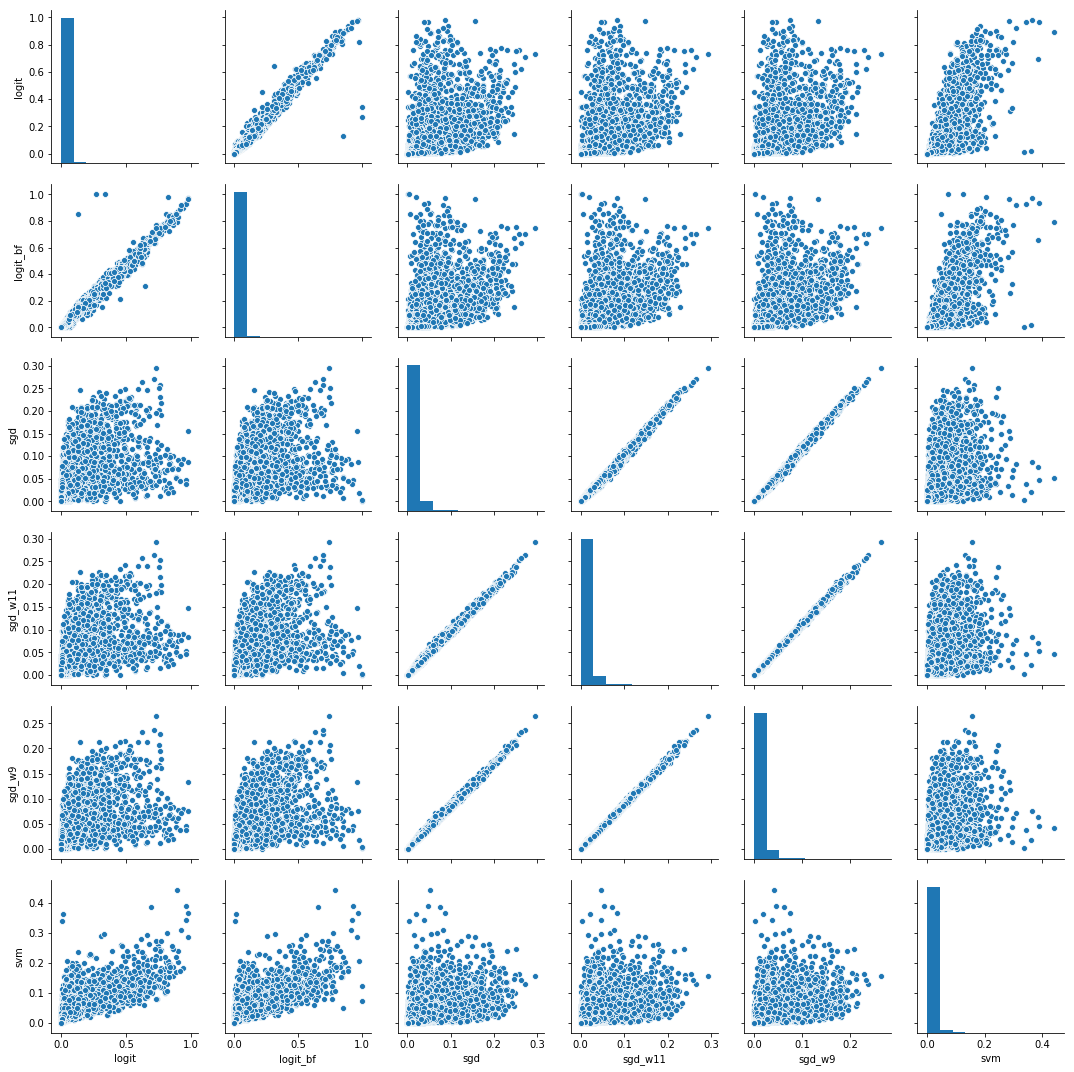

In [106]:
sns.pairplot(predict_df)

Let's randomly try to take means of different predictions (sgd is averaged).

In [107]:
final_predict = (logit_predict + logit_predict_2 + svm_predict + (sgd_predict + sgd_w9_predict + sgd_w11_predict)/3)/4

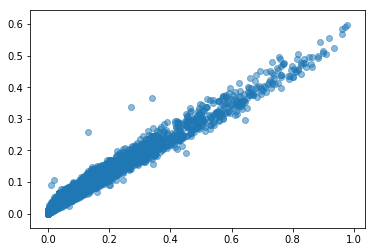

In [108]:
plt.scatter(logit_predict, final_predict, alpha=0.5)

In [109]:
write_to_submission_file(final_predict, 'results8.csv') # 0.95497

Ok, let's try not to do it randomly. Let's do it with most trusted predictions. These are logit predictions.

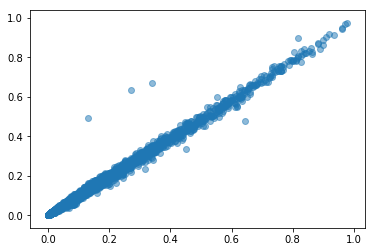

In [110]:
trusted_predict = (logit_predict_2 + logit_predict)/2
plt.scatter(logit_predict, trusted_predict, alpha = 0.5)

In [111]:
write_to_submission_file((logit_predict_2 + logit_predict)/2, 'results9.csv') # 0.95632

...which means the first suggestion is wrong. May be we should give the largest weight to best prediction and make noise from other predictions (which structurally greatly differ from our best prediction)

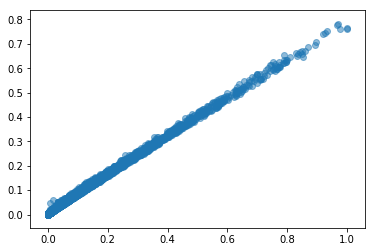

In [112]:
hybrid_predict = (6 * logit_predict_2 + svm_predict + (sgd_predict + sgd_w9_predict + sgd_w11_predict)/3)/8
plt.scatter(logit_predict_2, hybrid_predict, alpha = 0.5)

In [113]:
write_to_submission_file(hybrid_predict, 'results10.csv') # 0.95577

...no, doesn't seem that way. 

As you can see - these are pure random attempts. We could experiment with these for quite a long time. But this would be useful for competition, - not for the research. At least we reached top 9% (as for now) of public LB. And though i intended to break through **A2 strong baseline** baseline, this would take tougher attempts.

## 5. Conclusion

We took part in Kaggle inclass competition (https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). Although we used only linear models (which are best suited for this kind of tasks), we could reach some fair results in competition. Now we have 'boilerplate' for pipeline, which can be used for further predictions.

And trere is really not much to add. It's obvious that **time-series split** is the best validation strategy because we basically predict future by the past, **Roc auc score** - is the best possible metrics in this case, because we work with imbalanced set, **Logistic regression** is most likely the best model, because our train set is not too large, we can train our model offline (i didn't even mention the **Vowpal Wabbit** here, because it's absolutely pointless). The only real impact - is the feature analysis. I did my best trying to figure out, what features describe Alice properly. I can't say i succeeded too much (with my own features at least)... but as i stated earlier - this is the research project, not the recipe to climb up the Leaderboard.